### Libraries

In [1]:
import os
from os import listdir
from os.path import join, isfile
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from efficientnet_pytorch import EfficientNet
from torchvision.transforms import transforms, Lambda
import torchvision.transforms.functional as TF
from torch.utils.data import random_split
import random
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
import glob
# from torchvision.transforms import v2
# !pip install git+https://github.com/facebookresearch/fvcore.git


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pwd

'/scratch/student/shokoofa'

In [3]:
original_address = '/scratch/student/shokoofa'
# '/home/zahra.ghods'
# '/home/student/shokoofa/Downloads/dataset/'
# 'C:/echo/dataset
# '/scratch/student/shokoofa/'

In [4]:
paths = glob.glob(os.path.join(original_address + '/dataset/**/*', '*')) #numebr of all samples per patients
len(paths)

5303

### Load the csv file containing the image file names and corresponding labels

In [5]:
info_train = pd.read_csv(os.path.join(original_address , 'dataset/train_labels_ws.csv'))
info_val = pd.read_csv(os.path.join(original_address , 'dataset/val_labels_ws.csv'))
info_test = pd.read_csv(os.path.join(original_address , 'dataset/test_labels_ws.csv'))

### Define Transformers

In [6]:
class CustomCrop(object):
    """Crops the bottom 1/10 of the height and 1/8 of the width of the image."""
    def __call__(self, img):
        w, h = img.size
        new_h = h - h // 15
        top = 0
        left = w // 10
        return img.crop((left, top, w, new_h))


to_pil = ToPILImage()
    
all_data_transform = transforms.Compose([
    CustomCrop(),
#     transforms.Resize((224, 224)), #resNext50
    # transforms.Resize((256, 256)), #efficientNet-b0
    transforms.Resize((288, 288)), #efficientNet-b2
    # transforms.Resize((299, 299)), # JUST FOR INCEPTION
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Lambda(lambda x: x/255),
])


### Same augmentation to all frames of a sample

In [7]:
class AddGaussianNoise:
    """Adds Gaussian noise to a tensor."""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

class ApplySameTransformToAllFrames:
    def __init__(self):
        self.to_tensor = transforms.ToTensor()
        self.color_jitter = transforms.ColorJitter(brightness=0.1, contrast=0.1)

    def get_random_parameters(self):
        # This will generate a new set of random parameters each time it's called
        params = {
            'do_horizontal_flip': random.random() < 0.2,
            'do_vertical_flip': random.random() < 0.2,
            'angle': random.uniform(-10, 10),
            'apply_color_jitter': random.random() < 0.2,
            'apply_noise': random.random() < 0.2
        }
        return params

    def __call__(self, list_of_images):
        # Convert to PIL Images if needed
        list_of_images = [Image.fromarray(image) if isinstance(image, np.ndarray) else image for image in list_of_images]
        pars = self.get_random_parameters()

        # Apply the same transformations to all frames in this sample
        transformed_images = [self.apply_random_transforms(img, pars) for img in list_of_images]
        return transformed_images

    def apply_random_transforms(self, img, params):

        if params['do_horizontal_flip']:
            img = TF.hflip(img)
        if params['do_vertical_flip']:
            img = TF.vflip(img)
        img = TF.rotate(img, params['angle'])
        if params['apply_color_jitter']:
            img = self.color_jitter(img)
        img = self.to_tensor(img)
        if params['apply_noise']:
            img = AddGaussianNoise()(img)

        return img

### Map images to their labels

In [8]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, starts, ends, transform, training_transform = False):
        self.paths = paths
        self.labels = labels
        self.starts = starts
        self.ends = ends
        self.transform = transform
        self.training_transform = training_transform
        self.transform = transform
        self.valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
                            }

    def __len__(self):
        return len(self.paths)

    def preprocessing(self, image_array, k = 100):
        slices, ch, height, width = image_array.shape

        mask = torch.zeros((ch, height, width), dtype=torch.uint8)
        steps = min(k, slices)
        for i in range(steps - 1):
            mask[image_array[i, :, :, :] != image_array[i + 1, :, :, :]] = 1

        output = image_array * mask
        return output

    def address(self,index):
        return original_address + '/dataset/' + self.paths[index]
    
    def __getitem__(self, index):
        
        filepath = original_address + '/dataset/' + self.paths[index]
        label = self.labels[index]
        label = torch.tensor([self.valid_labels[str(label)]])

        # sort the image in based on the order of the slices saved in the folder
        # imgs_paths = sorted(glob.glob(os.path.join(filepath, '*')), key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))
        addresses = []
        for i in range(self.starts[index], self.ends[index]+1):
            addresses.append(filepath + '/' + filepath.split('/')[-1] + '_' + str(i) + '.jpeg')

        imgs_paths = sorted(addresses, key=lambda name: int(os.path.basename(name).split('_')[-1].split('.')[0]))

        images_list = []
        for img_path in imgs_paths:
            image = Image.open(img_path)
            if self.transform:
                image = self.transform(image)
            images_list.append(image)


        # creating a 3D tensor image
        sequence_tensor = torch.stack(images_list)
        # chunks = self.sliding_window(sequence_tensor)
        
        preprocessed_d = self.preprocessing(sequence_tensor)
            

        # video augmentation on all slices
        if self.training_transform:
            preprocessed_d = np.stack([to_pil(image) for image in preprocessed_d])
            train_transform = ApplySameTransformToAllFrames()
            preprocessed_d = train_transform(preprocessed_d)
            preprocessed_d = torch.stack([image for image in preprocessed_d])

        # Return the image and label as tensors
        return preprocessed_d, label


In [9]:
def visualization(image, label):
  plt.figure(figsize= (10,8))
  # im = Image.fromarray(image.permute(1,2,0))
  # plt.imshow(image.permute(1,2,0))
  plt.imshow(image, cmap= 'gray')
  plt.title(label.item())
  plt.xticks([])
  plt.yticks([])
  plt.show()

### Load the train dataset from the folder

In [10]:
train_data = CustomDataset(info_train['path'], info_train['label'],info_train['start'], info_train['end'], transform=all_data_transform, training_transform = False)
val_data = CustomDataset(info_val['path'], info_val['label'],info_val['start'], info_val['end'], transform=all_data_transform, training_transform = False)
test_data = CustomDataset(info_test['path'], info_test['label'],info_test['start'], info_test['end'], transform=all_data_transform, training_transform = False)

In [51]:
# train_data[20][0].shape
len(train_data)

1715

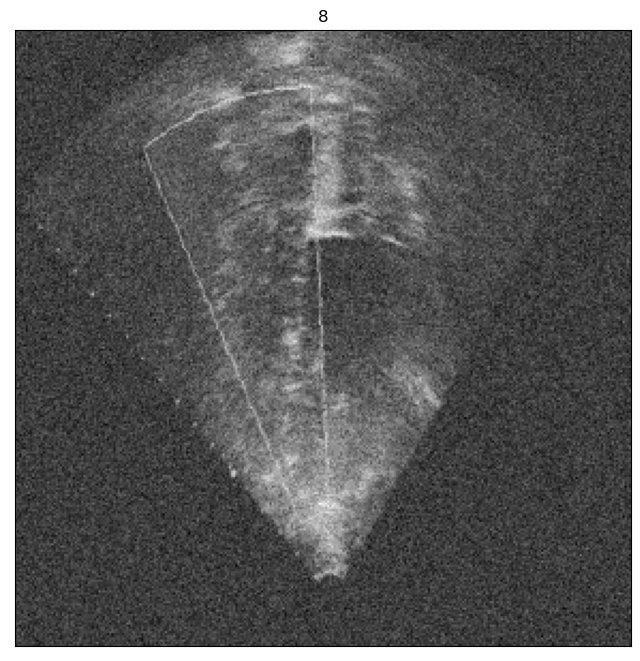

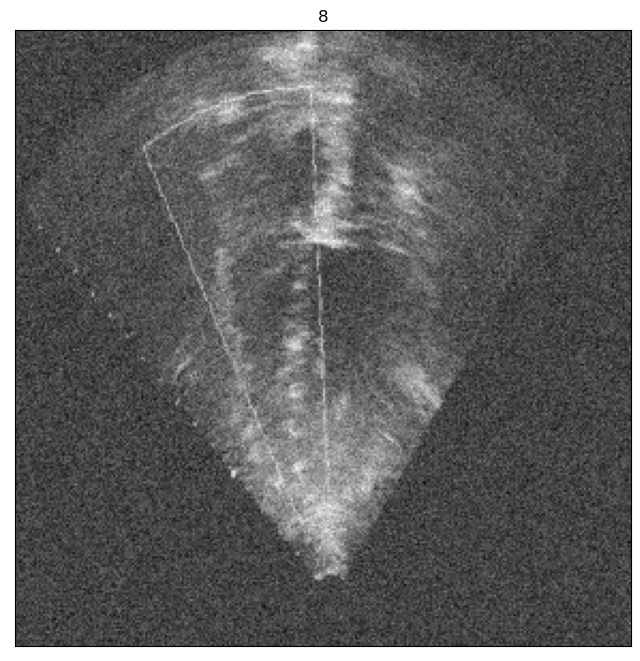

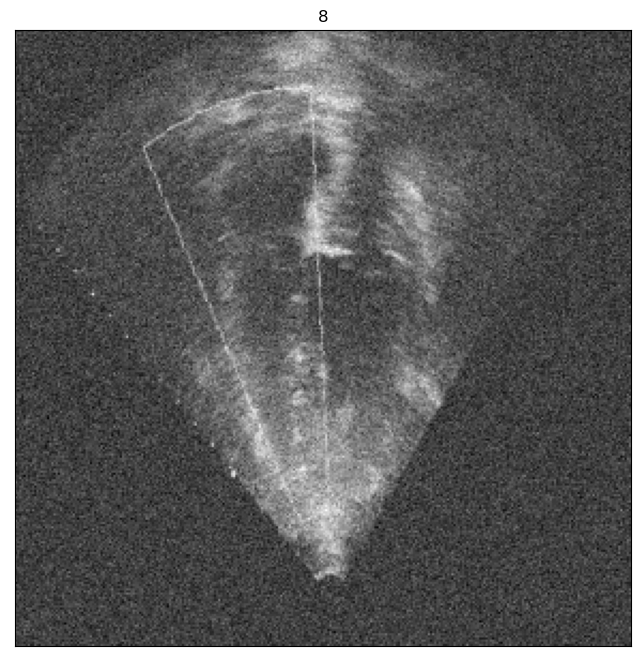

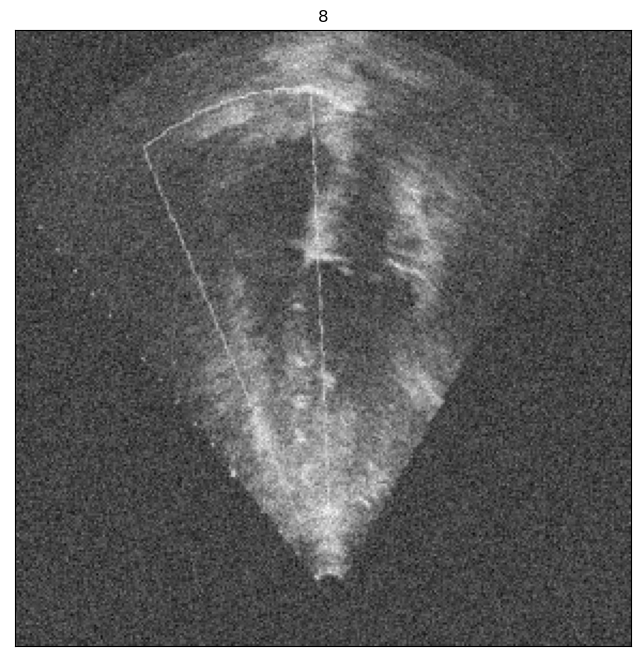

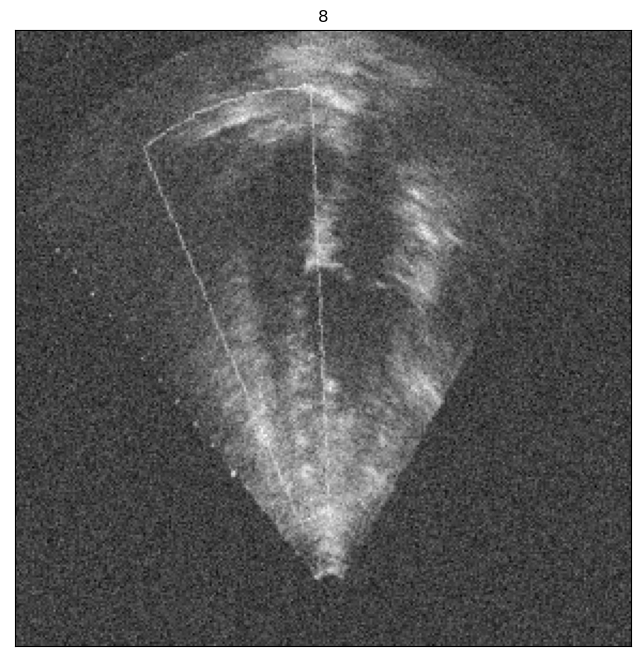

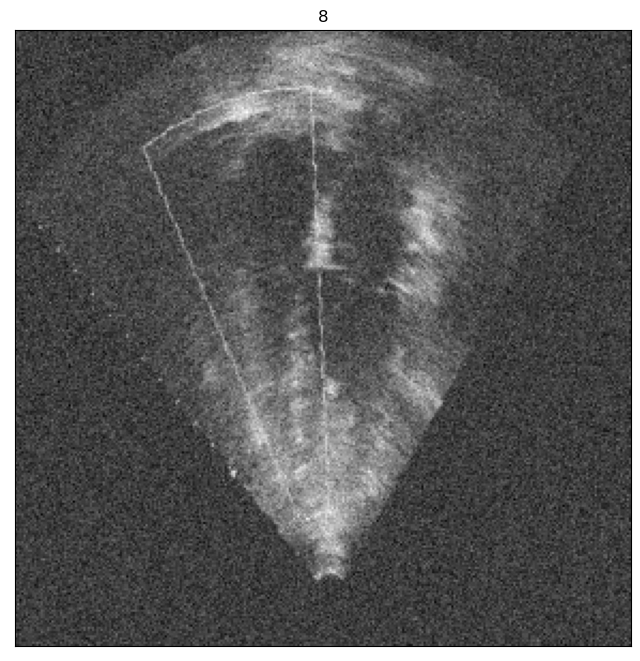

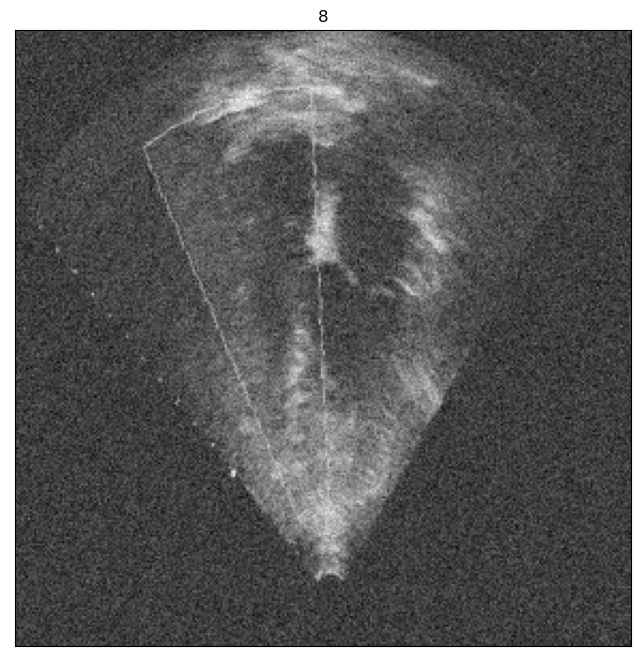

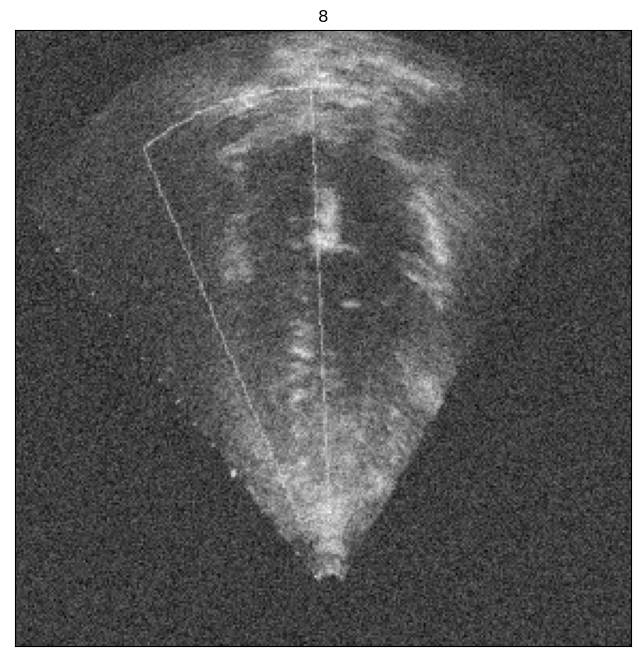

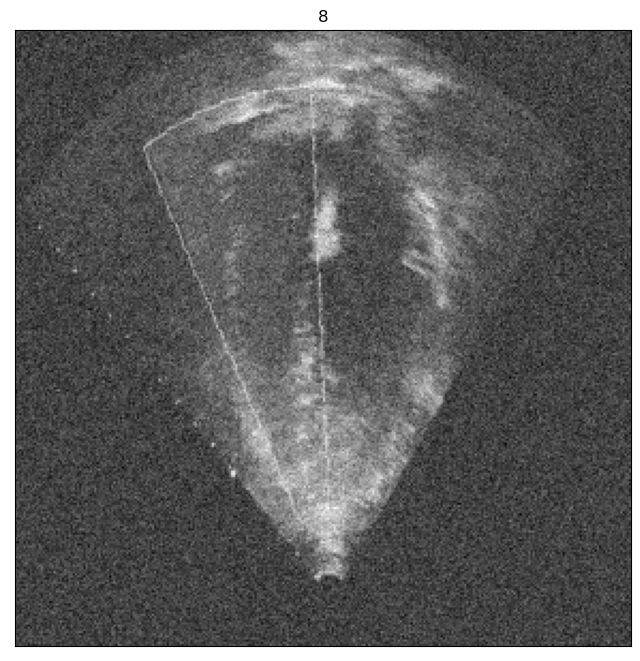

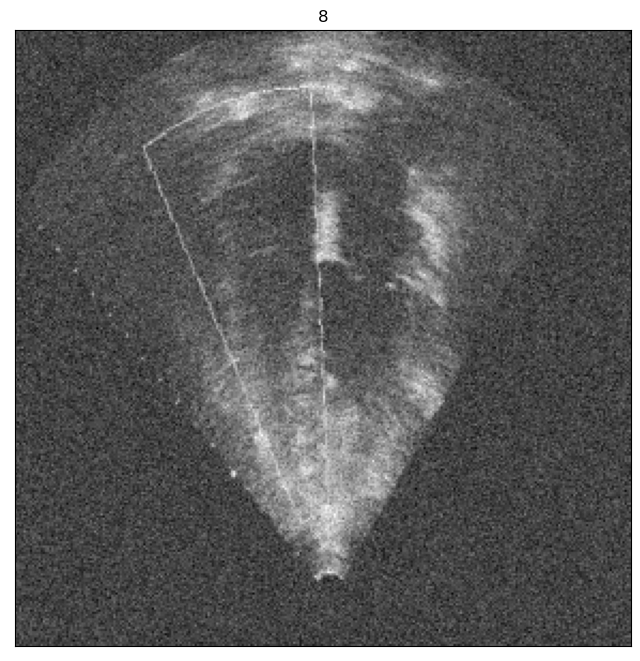

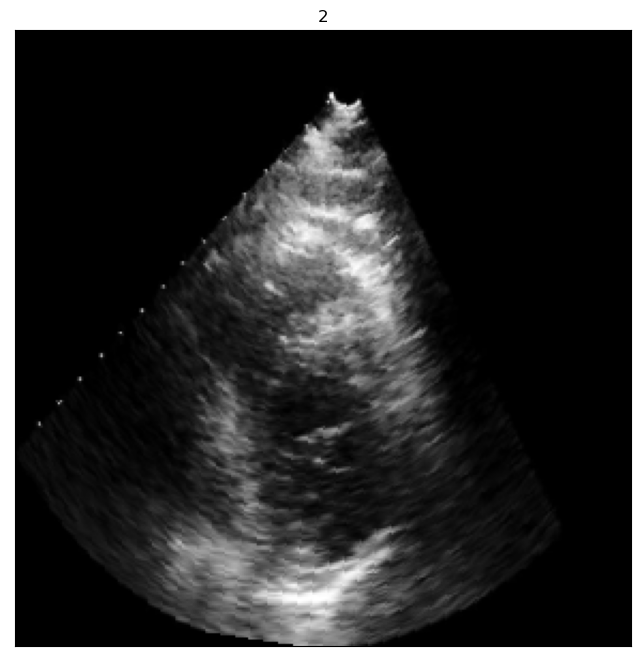

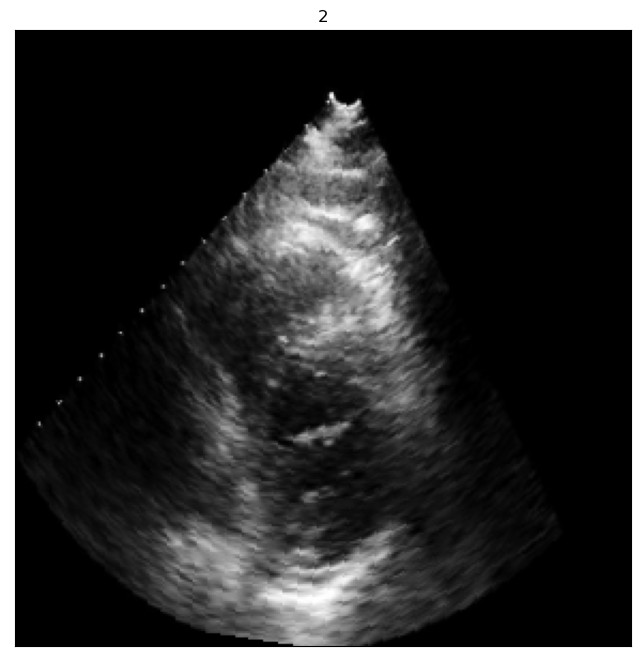

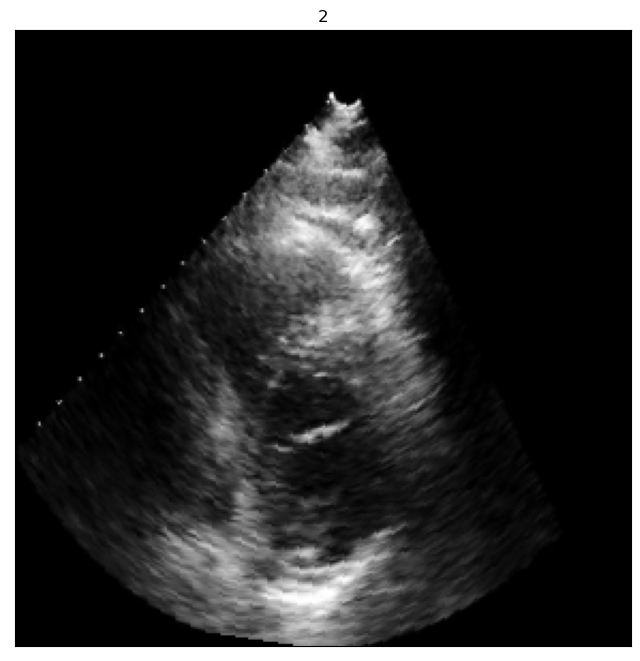

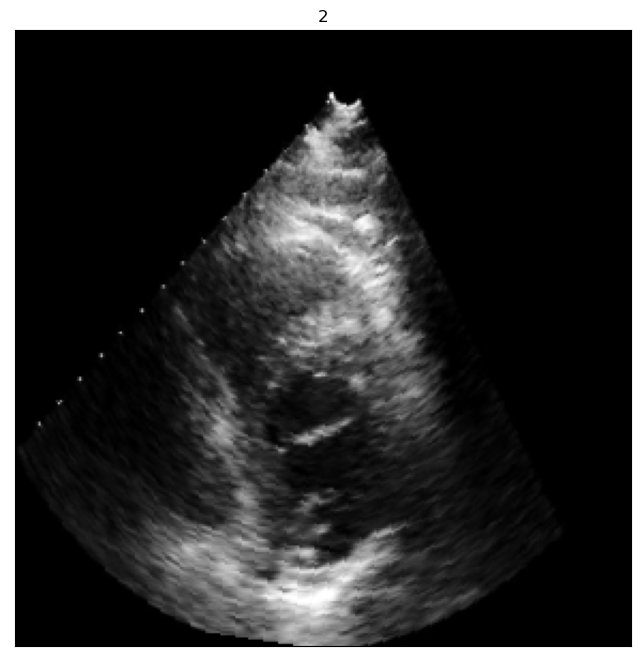

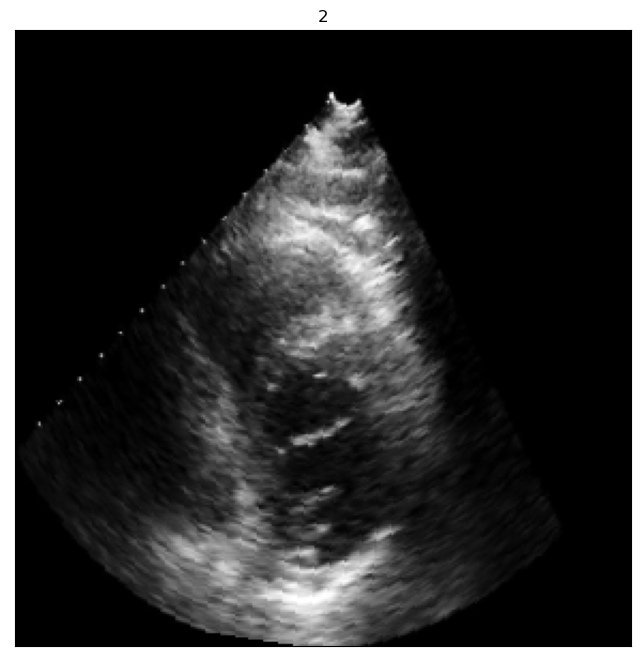

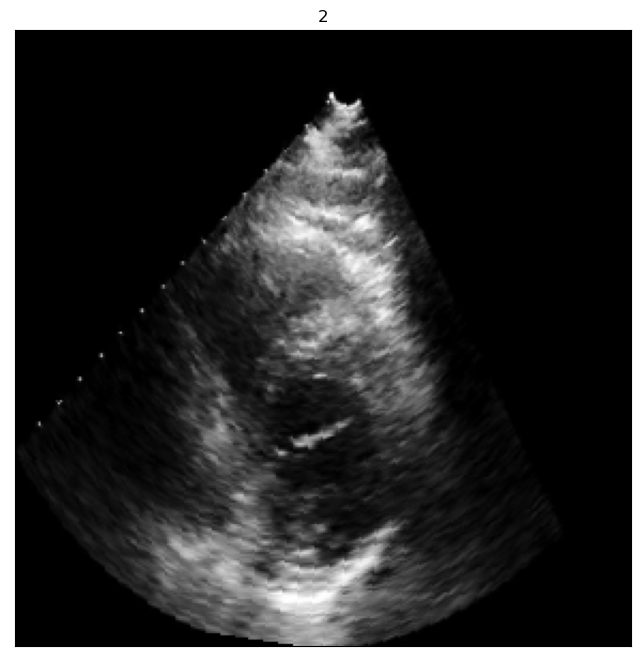

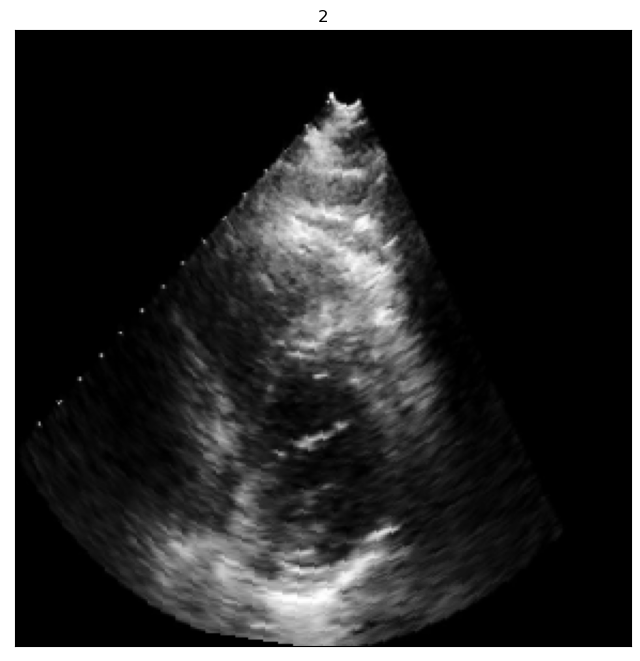

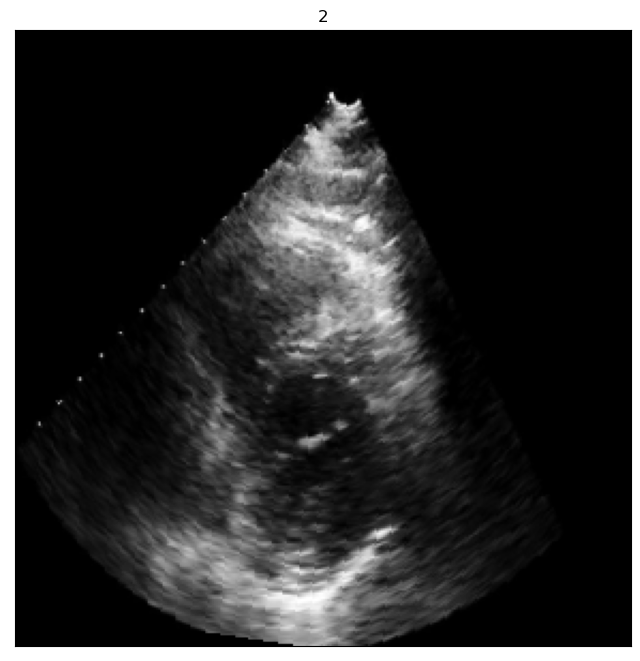

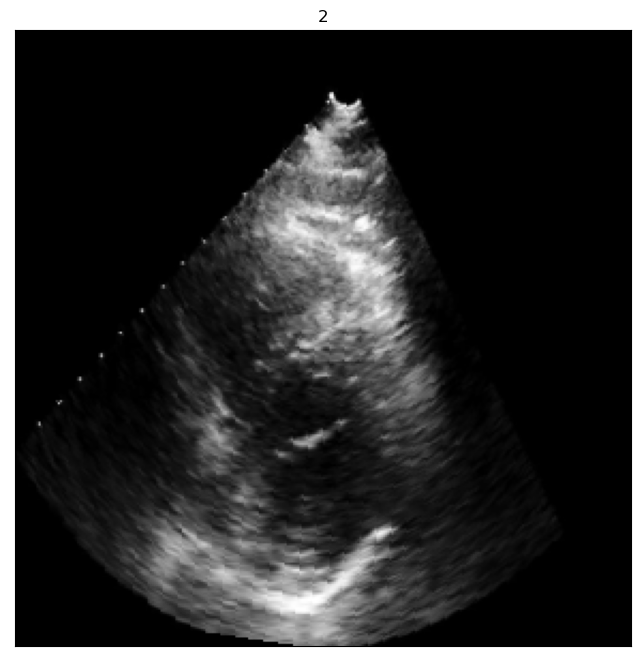

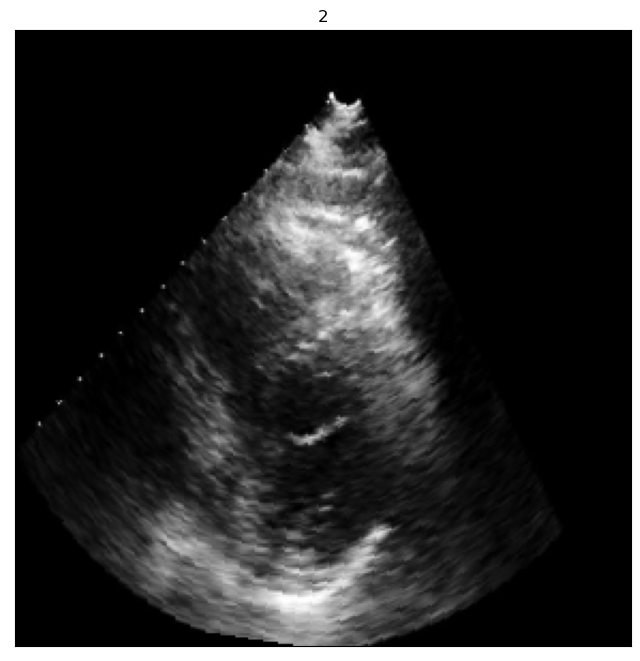

In [12]:
dt = train_data[10][0][:]
lb = train_data[10][1]
num  = len(dt)
for i in range(num):
    visualization(dt[i,-1], lb)
    
dt1 = train_data[60][0][:]
lb1 = train_data[60][1]
for i in range(num):
    visualization(dt1[i,-1], lb1)

### Create data loaders for the train and validation sets



In [11]:
train_loader = DataLoader(train_data, batch_size=32, drop_last=True, shuffle=True, pin_memory=True, num_workers= 4)
#, pin_memory=True, num_workers= 8, persistent_workers=True)

val_loader = DataLoader(val_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4)
#pin_memory=True, num_workers= 8, persistent_workers=True)

test_loader = DataLoader(test_data, batch_size=32, drop_last=True, shuffle=False, pin_memory=True, num_workers= 4)
#pin_memory=True, num_workers= 8, persistent_workers=True)


In [46]:
for img, lbl in train_loader:
    print(img.shape)
    break

torch.Size([32, 10, 3, 288, 288])


### Define the neural network model architecture

In [12]:
class CNNLSTM(nn.Module):
    def __init__(self, in_channels, cnn_output_size, num_classes):
        super(CNNLSTM, self).__init__()

        self.hidden_size = 1000
        self.num_layers = 2
        self.num_classes = num_classes
        self.cnn_output_size = cnn_output_size

        # self.conv = torchvision.models.resnet18(pretrained = True)
        # self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv = torchvision.models.inception_v3(weights='DEFAULT')
        self.conv = torchvision.models.efficientnet_b2(weights='DEFAULT')
        # self.conv.trainable = False
        # for param in self.conv.parameters():
        #     param.requires_grad = False

        self.lstm = nn.LSTM(self.cnn_output_size, self.hidden_size, self.num_layers, batch_first=True)
        # self.classifier_layer = nn.Sequential( 
        #     nn.Linear(self.hidden_size, 256), 
        #     nn.ReLU(),
        #     nn.Dropout(0.2), 
        #     nn.Linear(256, num_classes))
        self.classifier_layer = nn.Sequential( nn.Linear(self.hidden_size, num_classes))

    def forward(self, x):
        batch_size , seq_len, C, H, W = x.size()
        c_in = x.view( batch_size * seq_len, C, H, W)
        # print(c_in.shape)
        c_out = self.conv(c_in)
        # if self.training: #JUST FOR INCEPTION
        #     c_out = c_out[0]
        
        # c_out = F.adaptive_avg_pool2d(c_out, (1,1))
        
        # c_out = c_out.view(c_out.size(0), -1)
        # print(c_out)
        lstm_in = c_out.view(batch_size, seq_len, -1)
        # print(lstm_in.shape)
        lstm_out, _ = self.lstm(lstm_in)

        lstm_out = lstm_out[:, -1, :]

        output = self.classifier_layer(lstm_out)
        return output


cnn_output_size = 1000
model = CNNLSTM(3,cnn_output_size, 11)

In [15]:
# class CNN3D(nn.Module):
#     def __init__(self, cnn_output_size, num_classes):
#         super(CNN3D, self).__init__()

#         self.num_classes = num_classes
#         self.cnn_output_size = cnn_output_size

#         self.conv3 = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
#         self.classifier_layer = nn.Sequential( nn.Linear(self.cnn_output_size, num_classes))

#     def forward(self, x):
#         batch_size , seq_len, C, H, W = x.size()
#         c_in = x.view( batch_size, C, seq_len, H, W)
#         # print(c_in.shape)
#         c_out = self.conv3(c_in)
#         C_out = c_out.view(batch_size, -1)
#         output = self.classifier_layer(c_out)
#         return output


# cnn_output_size = 400
# model = CNN3D(cnn_output_size, 11)

In [16]:
# input1 = torch.rand(8, 10, 3, 299, 299)
input2 = torch.rand(8, 10, 3, 299, 299)
model.eval()
# print(model(input1))
print(model(input2))

tensor([[ 0.0242, -0.0058, -0.0415,  0.0104, -0.0333, -0.0199,  0.0341, -0.0561,
         -0.0407, -0.0126, -0.0604],
        [ 0.0238, -0.0033, -0.0420,  0.0120, -0.0370, -0.0188,  0.0373, -0.0553,
         -0.0423, -0.0123, -0.0627],
        [ 0.0223, -0.0020, -0.0423,  0.0117, -0.0376, -0.0190,  0.0376, -0.0557,
         -0.0421, -0.0158, -0.0615],
        [ 0.0262, -0.0008, -0.0419,  0.0104, -0.0370, -0.0153,  0.0364, -0.0561,
         -0.0421, -0.0157, -0.0608],
        [ 0.0243, -0.0018, -0.0416,  0.0087, -0.0355, -0.0165,  0.0379, -0.0559,
         -0.0402, -0.0121, -0.0647],
        [ 0.0250, -0.0015, -0.0399,  0.0114, -0.0337, -0.0183,  0.0370, -0.0549,
         -0.0411, -0.0132, -0.0603],
        [ 0.0226, -0.0006, -0.0422,  0.0137, -0.0378, -0.0176,  0.0387, -0.0550,
         -0.0410, -0.0128, -0.0619],
        [ 0.0247, -0.0021, -0.0417,  0.0124, -0.0369, -0.0169,  0.0392, -0.0539,
         -0.0420, -0.0129, -0.0636]], grad_fn=<AddmmBackward0>)


### Define loss and optimizer

In [17]:
torch.cuda.is_available()
# !export CUDA_VISIBLE_DEVICES=0

True

In [18]:
!nvidia-smi

Mon May  6 15:28:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:41:00.0 Off |                  Off |
| 30%   46C    P8              30W / 300W |     20MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = torch.device('cuda:0')
model.to(device)
model.lstm.flatten_parameters() 
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model)


# model.lstm.flatten_parameters() 
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1, momentum=0.9)

print(device)

Let's use 2 GPUs!
cuda


### Train the model

In [56]:
def evaluate(model, loader, device, criterion, mode='validation'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) #TODO: if number of sampels increase more than one it SHOULD increase as well
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()
      # print(predictions, labels, labels == predictions, total_correct, total, images.size(0))

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} epoch {epoch}: Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss



In [64]:
# model = model.to(device)
epochs = 15
# BATCH_SIZE = 64
accs = []
losses = []
for epoch in range(epochs):
  model.train()
  total = 0
  running_loss = 0.
  running_corrects = 0
  val_loss = 0.0
  # epochs_no_improve = 0
  best_val_loss = float('inf')
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    # print(images)
    # print(outputs)
    labels = labels.squeeze(1)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
    optimizer.step()

    total += images.size(0)
    _, predictions = outputs.max(1)
    # print(predictions, labels)
    running_loss += loss.item() * images.size(0)
    running_corrects += (predictions == labels).sum()
    # print(i, running_corrects)
    # total_loss += loss.item() * images.size(0)
  #   if (i%10 == 0):
  #     print(total_loss/total)
  # accuracy = total_correct / total
    # break
#     print(i, running_corrects)
  if (epoch%10 == 0):
    torch.save(model.state_dict(), (f'/scratch/student/shokoofa/model{epoch}.pth'))
  
  epoch_loss = running_loss / total
  epoch_acc = running_corrects / total
  accs.append(epoch_acc)
  losses.append(epoch_loss)
  # loss = total_loss / total
  print(f'Train epoch {epoch}: Loss({epoch_loss:6.4f}, Accuracy ({epoch_acc:6.5f}) )')
  val_acc, val_loss = evaluate(model, val_loader, device, criterion, mode='valid')
  accs.append(val_acc)
  losses.append(val_loss)

  print('---')

  if(val_loss < best_val_loss):
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save(model.state_dict(), (f'/home/student/shokoofa/Downloads/res_model{epoch}.pth'))
  else:
    epochs_no_improve += 1

  if epochs_no_improve > 7:
    print('no further improvement')
    break


0 tensor(12, device='cuda:0')
1 tensor(27, device='cuda:0')
2 tensor(41, device='cuda:0')
3 tensor(57, device='cuda:0')
4 tensor(69, device='cuda:0')
5 tensor(78, device='cuda:0')
6 tensor(93, device='cuda:0')
7 tensor(111, device='cuda:0')
8 tensor(126, device='cuda:0')
9 tensor(140, device='cuda:0')
10 tensor(154, device='cuda:0')
11 tensor(173, device='cuda:0')
12 tensor(188, device='cuda:0')
13 tensor(209, device='cuda:0')
14 tensor(227, device='cuda:0')
15 tensor(237, device='cuda:0')
16 tensor(247, device='cuda:0')
17 tensor(263, device='cuda:0')
18 tensor(279, device='cuda:0')
19 tensor(290, device='cuda:0')
20 tensor(310, device='cuda:0')
21 tensor(326, device='cuda:0')
22 tensor(346, device='cuda:0')
23 tensor(361, device='cuda:0')
24 tensor(382, device='cuda:0')
25 tensor(398, device='cuda:0')
26 tensor(417, device='cuda:0')
27 tensor(431, device='cuda:0')
28 tensor(447, device='cuda:0')
29 tensor(464, device='cuda:0')
30 tensor(477, device='cuda:0')
31 tensor(496, device='cu

KeyboardInterrupt: 

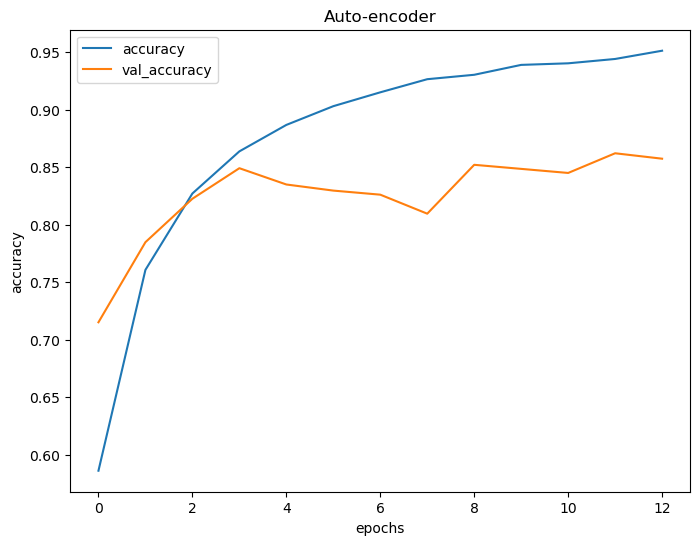

In [22]:
from numpy.core.multiarray import zeros
import matplotlib.pyplot as plt
import numpy as np


# Generate sample data
x = [i for i in range(0,len(accs)//2)]
y = [accs[i].cpu() for i in range(0,len(accs),2)]
z = [accs[i].cpu() for i in range(1,len(accs),2)]


# Create a new figure and set the size
fig = plt.figure(figsize=(8, 6))

# Add a new subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the line graph
ax.plot(x, y, label='accuracy')
ax.plot(x, z, label='val_accuracy')
ax.legend()
# Set the title and axis labels
ax.set_title('Auto-encoder')
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')

# Display the plot
plt.show()


In [27]:
len(train_loader)

480

In [16]:
model = CNNLSTM(3,1000, 11)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load('cnnLSTM-sw-acc84.pth', map_location= 'cpu'))
model.eval()

DataParallel(
  (module): CNNLSTM(
    (conv): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): MBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
              (1): SqueezeExcitation(
                (avgpool): AdaptiveAvgPool2d(output_size=1)
                (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            

In [1]:
def evaluate(model, loader, device, mode='Test'):
  model.eval()
  total_correct = 0
  total_loss = 0
  # BATCH_SIZE = 64
  total = 0
  for i, (images, labels) in enumerate(loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    with torch.no_grad():
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * images.size(0)
      total += images.size(0) 
      _, predictions = outputs.max(1)
      total_correct += (labels == predictions).sum()

  # print(total_correct, total, accuracy)
  loss = total_loss / total
  accuracy = total_correct / total
  print(f'{mode} Loss({loss:6.4f}),  Accuracy ({accuracy:6.4f}))')
  return accuracy, loss

evaluate(model, loader= test_loader, device = 'cuda')


/home/student/shokoofa/anaconda3/lib/python3.9/site-packages/torch/nn/modules/rnn.py:774: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:968.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


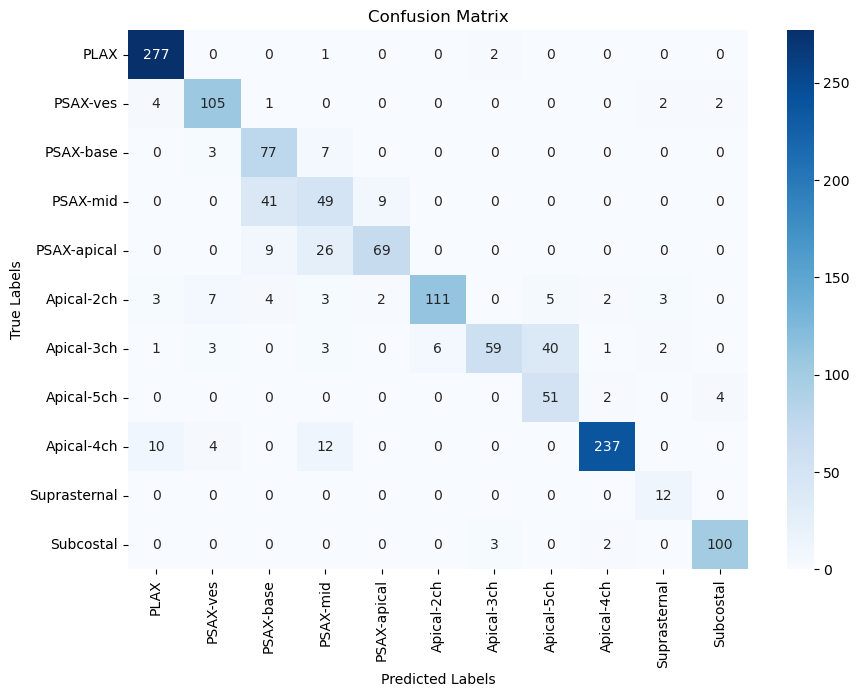

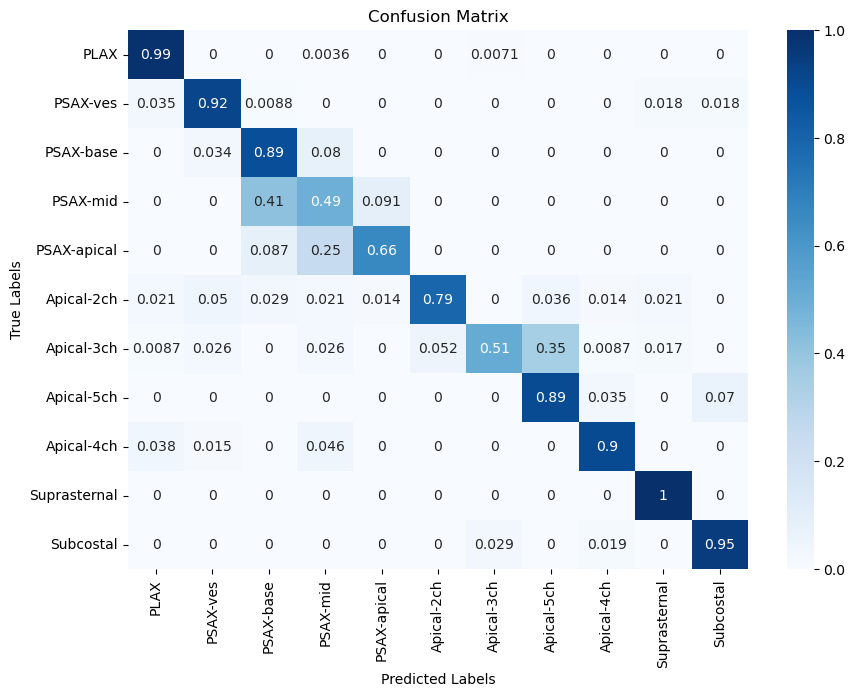

In [49]:
true_labels, pred_labels = [], []

valid_labels = {'PLAX': 0, 'PSAX-ves' : 1, 'PSAX-base' : 2, 'PSAX-mid' : 3,
                              'PSAX-apical' : 4, 'Apical-2ch' : 5, 'Apical-3ch' : 6,
                              'Apical-5ch' : 7, 'Apical-4ch' : 8, 'Suprasternal' : 9, 'Subcostal' : 10
               }

labels_name = valid_labels.keys()
model.eval()
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.squeeze(1)
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions.cpu().numpy())
        
cm = confusion_matrix(true_labels, pred_labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=labels_name, yticklabels=labels_name )
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# predictions == labels

In [ ]:
# model.load_state_dict(torch.load('/home/student/shokoofa/Downloads/model0.pth'))
# model.eval()

In [ ]:
# print(model(test_data[183][0].unsqueeze(0).to(device)))
# # test_data[0][0].unsqueeze(0).shape
# # images.size()

# test_data[183][1]

In [ ]:
# class CNN(nn.Module):
#     def __init__(self, in_channels):
#         super(CNN, self).__init__()

#         self.conv = EfficientNet.from_pretrained('efficientnet-b0')
#         self.conv.trainable = False
#         for param in self.conv.parameters():
#             param.requires_grad = False

#     def forward(self, x):
#         seq_len, C, H, W = x.size()
#         c_in = x.view( seq_len, C, H, W)
#         c_out = self.conv.extract_features(c_in)
#         pooled = F.adaptive_avg_pool2d(c_out, (1,1))
#         pooled = pooled.view(seq_len, -1)
#         return pooled


# # x = torch.rand((1, 20, 1, 32, 32))
# xx = [torch.rand( i, 3, 224, 224) for i in range(25,30)]
# net_cnn = CNN(1)
# for x in xx:
#     features = net_cnn(x)
#     print(features.shape)

In [ ]:
# class VGG(nn.Module):
#   def __init__(self, num_classes=100):
#     super().__init__()
#     self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#             nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=1, padding= 1),

#     )

#     self.adaptive_avg_pool2d = nn.AdaptiveAvgPool2d((6, 6))
#     self.flatten = nn.Flatten(start_dim=1)
#     self.classifier = nn.Sequential(
#             nn.Linear(256*256*512, num_classes),
#             nn.ReLU(inplace=True),
#             # nn.Linear(1000, 100),
#             # nn.ReLU(inplace=True),
#             # nn.Linear(1000, num_classes),
#             # nn.ReLU(inplace=True),
#         )

#   def forward(self, x):
#     x = self.features(x)
#     # x = self.adaptive_avg_pool2d(x)
#     x = self.flatten(x)
#     x = self.classifier(x)
#     return x

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break

In [ ]:
  # for i, (images, labels) in enumerate(train_loader):
  #   print(images.shape)
  #   break



In [ ]:
# torch.save(model.state_dict(), 'model.pt')
